# Source contributions

In [1]:
import pickle
import numpy as np
import xarray as xr
import pandas as pd
from calendar import monthrange
import matplotlib.pyplot as plt
import matplotlib as mpl

%matplotlib inline

#### Parameters:

In [2]:
# domain dimensions:
jmin, jmax = 159, 799
imin, imax = 1139, 2179
isize = imax - imin
jsize = jmax - jmin

# model result set:
folder_base = '/data/brogalla/run_storage/Pb-tuning-202302/'

colors = ['#ccb598', '#448d90', '#739f78', '#CC8741', '#cee7fd', '#b9c1c7']

In [3]:
years = [2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012]#, 2013, 2014, 2015, 2016, \
#          2017, 2018, 2019, 2020]

#### Load files:

In [4]:
mfile        = xr.open_dataset('/ocean/brogalla/GEOTRACES/data/ANHA12/ANHA12_mask_Pb-20230213.nc')
ANHA12_lon   = mfile['nav_lon'].values
ANHA12_lat   = mfile['nav_lat'].values
tmask        = mfile['tmask'].values
tmask_sub    = mfile['tmask'].values[0,:,imin:imax,jmin:jmax]
land_mask = np.ma.masked_where((tmask_sub[:,:,:] > 0.1), tmask_sub[:,:,:]) 

mesh      = xr.open_dataset('/ocean/brogalla/GEOTRACES/data/ANHA12/ANHA12_mesh1.nc')
e1t_base  = mesh['e1t'].values[0,imin:imax,jmin:jmax]
e2t_base  = mesh['e2t'].values[0,imin:imax,jmin:jmax]
e3t       = mesh['e3t_0'].values[0,:,imin:imax,jmin:jmax]
e3t_masked = np.ma.masked_where((tmask_sub[:,:,:] < 0.1), e3t)
nav_lev   = mesh['nav_lev'].values
lons      = mesh['nav_lon'].values

e1t       = np.tile(e1t_base, (50,1,1))
e2t       = np.tile(e2t_base, (50,1,1))
volume    = e1t*e2t*e3t
area_base = e1t_base*e2t_base
volume_masked = np.ma.masked_where((tmask_sub[:,:,:] < 0.1), volume)
area_masked   = np.ma.masked_where((tmask_sub[0,:,:] < 0.1), area_base)

Find grid cell volume and thickness at ocean floor:

In [5]:
tmask_bot = np.copy(tmask_sub)
tmask_bot[0,:,:] = 1
e3t_mask = np.ma.masked_where((tmask_bot[:,:,:] < 0.1), e3t[:,:,:])

# find bottom grid cell index:
ind = np.array(np.ma.notmasked_edges(e3t_mask[:,:,:], axis=0))

# array of shape (isize, jsize) containing bottom grid cell index
index_bottom = np.ma.masked_where((tmask_sub[0,:,:] < 0.1), ind[1][0][:].reshape(isize,jsize))

In [6]:
e3t_bot = np.zeros((isize,jsize))
vol_bot = np.zeros((isize,jsize))

for i in range(0, isize):
    for j in range(0,jsize):
        k = index_bottom[i,j]
        try:
            e3t_bot[i,j] = e3t[k,i,j]
            vol_bot[i,j] = volume[k,i,j]
        except:
            e3t_bot[i,j] = np.nan
            vol_bot[i,j] = np.nan
        
e3t_bottom    = np.ma.masked_where((tmask_sub[0,:,:] < 0.1) | np.isnan(e3t_bot), e3t_bot)
volume_bottom = np.ma.masked_where((tmask_sub[0,:,:] < 0.1) | np.isnan(vol_bot), vol_bot)

#### Functions:

Compare values from monthly output for dust with the forcing field that I'm applying.

In [22]:
def load_results(folder, year, experiment):
    
    dpb_riv     = np.empty((12,isize,jsize)); dpb_sed = np.empty((12,isize,jsize)); 
    dpb_atmdust = np.empty((12,isize,jsize)); dpb_atmbc = np.empty((12,isize,jsize)); 
    dpb_icedust = np.empty((12,isize,jsize)); dpb_icebc = np.empty((12,isize,jsize));
    dpb_sedice  = np.empty((12,isize,jsize)); dpb_priv = np.empty((12,isize,jsize));
    
    for i, month in enumerate(range(1,13)):
        file_name = f'ANHA12_EXH006_1m_{year}0101_{year}1231_comp_{year}{month:02}-{year}{month:02}.nc'
        with xr.open_dataset(folder+file_name) as file:
            dpb_riv[i,:,:]     = file['dpbriv'].values[0,:,:]
            dpb_priv[i,:,:]    = file['ppbriv'].values[0,:,:]
            dpb_sed[i,:,:]     = file['dpbsed'].values[0,:,:]
            dpb_sedice[i,:,:]  = file['dpbsedice'].values[0,:,:]
            dpb_atmdust[i,:,:] = file['dpbatmdust'].values[0,:,:]
            dpb_atmbc[i,:,:]   = file['dpbatmbc'].values[0,:,:]
            dpb_icedust[i,:,:] = file['dpbicedust'].values[0,:,:]
            dpb_icebc[i,:,:]   = file['dpbicebc'].values[0,:,:]
    if experiment=='nospm':
        dpb_priv[:,:,:]   =  0
    elif experiment=='noice':
        dpb_sedice[:,:,:] = 0
    elif experiment=='noresus':
        dpb_sed[:,:,:]    = 0

    return dpb_riv, dpb_priv, dpb_sed, dpb_sedice, dpb_atmbc, dpb_atmdust, dpb_icebc, dpb_icedust

In [8]:
def calculate_contribution(folder, year=2002, experiment='ref'):
    # Calculate the contribution of the model components
    
    # load contributions from file
    dpb_riv, dpb_priv, dpb_sed, dpb_sedice, dpb_atmbc, dpb_atmdust, dpb_icebc, dpb_icedust = \
                       load_results(folder, year, experiment)
    
    tmask_surf    = np.empty(dpb_riv.shape)
    tmask_surf[:] = tmask_sub[0,:,:]
    
    # Momentary contribution: moles / second (from moles / L / s --> moles / m3 / s --> moles / s)
    # Mask is for the points associated with the specified region. 
    priv    = np.ma.masked_where((tmask_surf < 0.1), dpb_priv)    * volume_masked[0,:,:] * 1e3
    riv     = np.ma.masked_where((tmask_surf < 0.1), dpb_riv)     * volume_masked[0,:,:] * 1e3
    sedice  = np.ma.masked_where((tmask_surf < 0.1), dpb_sedice)  * volume_masked[0,:,:] * 1e3
    atmdust = np.ma.masked_where((tmask_surf < 0.1), dpb_atmdust) * volume_masked[0,:,:] * 1e3
    atmbc   = np.ma.masked_where((tmask_surf < 0.1), dpb_atmbc)   * volume_masked[0,:,:] * 1e3
    icedust = np.ma.masked_where((tmask_surf < 0.1), dpb_icedust) * volume_masked[0,:,:] * 1e3
    icebc   = np.ma.masked_where((tmask_surf < 0.1), dpb_icebc)   * volume_masked[0,:,:] * 1e3
    # Calculate contributions to the upper water column, so mask locations where sediment resuspension is added in the deep.
    resus   = np.ma.masked_where(np.tile(index_bottom, (12,1,1)) > 19, dpb_sed) * volume_bottom * 1e3
    
    # Yearly contribution to domain: moles / year (from moles / s / month --> moles / month --> moles / year)
    total_yearly = {'atm_dust': 0, 'atm_bc': 0, 'ice_dust': 0, 'ice_bc': 0, 
                    'runoff'  : 0, 'part_runoff': 0, 'resus': 0, 'sed_ice': 0};
    for month in range(1,13):  
        days_in_month = monthrange(year, month)[1]
        if days_in_month == 29: days_in_month = 28 # ignore leap year
        dt            = 3600*24*days_in_month
        
        total_yearly['atm_dust']    = total_yearly['atm_dust']    + np.ma.sum(atmdust[month-1,:,:],axis=(0,1)) * dt
        total_yearly['atm_bc']      = total_yearly['atm_bc']      + np.ma.sum(atmbc[month-1,:,:],axis=(0,1))   * dt
        total_yearly['ice_dust']    = total_yearly['ice_dust']    + np.ma.sum(icedust[month-1,:,:],axis=(0,1)) * dt
        total_yearly['ice_bc']      = total_yearly['ice_bc']      + np.ma.sum(icebc[month-1,:,:],axis=(0,1))   * dt
        total_yearly['runoff']      = total_yearly['runoff']      + np.ma.sum(riv[month-1,:,:],axis=(0,1))     * dt
        total_yearly['part_runoff'] = total_yearly['part_runoff'] + np.ma.sum(priv[month-1,:,:],axis=(0,1))    * dt
        total_yearly['resus']       = total_yearly['resus']       + np.ma.sum(resus[month-1,:,:],axis=(0,1))   * dt
        total_yearly['sed_ice']     = total_yearly['sed_ice']     + np.ma.sum(sedice[month-1,:,:],axis=(0,1))  * dt
    
    # Average yearly contribution over domain: moles / m2 / year
    ave_yearly = total_yearly.copy()
    for key in ave_yearly:
        if key == 'ads':
            ave_yearly[key] = ave_yearly[key]/(np.ma.sum(area_masked[:,:])*nav_lev[17]) # PML layer ave contribution
        else:
            ave_yearly[key] = ave_yearly[key]/np.ma.sum(area_masked[:,:])
 
    return total_yearly, ave_yearly

In [9]:
def print_annual_averages(totals, averages):

    print(f'Annual average values')
    print('----------------------------------------------------------------')
    total_annual = sum(totals.values())
    
    strlen=55;
    # Total annual contribution multiplied by 1e-6 to convert to Mmol
    print(f"{'Total annual contribution of Pb [Mmol/yr]:':<{strlen}}"     + f" {total_annual         *1e-6:<8.2f} ")
    print(f"{'-- Dissolved runoff':<{strlen}}"                            + f" {totals['runoff']     *1e-6:<8.2f}")
    print(f"{'-- Dissolved-particulate exchange runoff':<{strlen}}"       + f" {totals['part_runoff']*1e-6:<8.2f}")
    print(f"{'-- Sediment resuspension':<{strlen}}"                       + f" {totals['resus']      *1e-6:<8.2f}")
    print(f"{'-- Sediment released by sea ice':<{strlen}}"                + f" {totals['sed_ice']    *1e-6:<8.2f}")
    print(f"{'-- Natural aerosols released by sea ice':<{strlen}}"        + f" {totals['ice_dust']   *1e-6:<8.2f}")
    print(f"{'-- Anthropogenic aerosols released by sea ice':<{strlen}}"  + f" {totals['ice_bc']     *1e-6:<8.2f}")
    print(f"{'-- Natural aerosol deposition':<{strlen}}"                  + f" {totals['atm_dust']   *1e-6:<8.2f}") 
    print(f"{'-- Anthropogenic aerosol deposition':<{strlen}}"            + f" {totals['atm_bc']     *1e-6:<8.2f}") 

    # Percent is calculated from sum of component contribution over all months / total contributions 
    print('----------------------------------------------------------------')
    print('Total annual contribution of Pb [%]:') 
    print(f"{'-- Dissolved runoff ':<{strlen}}"                            + f" {totals['runoff']     *100/total_annual:<8.2f}")
    print(f"{'-- Dissolved-particulate exchange runoff ':<{strlen}}"       + f" {totals['part_runoff']*100/total_annual:<8.2f}")
    print(f"{'-- Sediment resuspension ':<{strlen}}"                       + f" {totals['resus']      *100/total_annual:<8.2f}")
    print(f"{'-- Sediment released by sea ice ':<{strlen}}"                + f" {totals['sed_ice']    *100/total_annual:<8.2f}")
    print(f"{'-- Natural aerosols released by sea ice ':<{strlen}}"        + f" {totals['ice_dust']   *100/total_annual:<8.2f}")
    print(f"{'-- Anthropogenic aerosols released by sea ice ':<{strlen}}"  + f" {totals['ice_bc']     *100/total_annual:<8.2f}")
    print(f"{'-- Natural aerosol deposition ':<{strlen}}"                  + f" {totals['atm_dust']   *100/total_annual:<8.2f}") 
    print(f"{'-- Anthropogenic aerosol deposition ':<{strlen}}"            + f" {totals['atm_bc']     *100/total_annual:<8.2f}") 

    # Average annual contribution converted to millimol
    print('----------------------------------------------------------------')
    print(f"{'Average annual contribution of Pb [micromol/m2/yr]:':<{strlen}}" + 
          f"{sum(ave_yearly.values())*1e6:<8.2f}")
    print(f"{'-- Dissolved runoff ':<{strlen}}"                            + f" {averages['runoff']     *1e6:<8.2f}")
    print(f"{'-- Dissolved-particulate exchange runoff ':<{strlen}}"       + f" {averages['part_runoff']*1e6:<8.2f}")
    print(f"{'-- Sediment resuspension ':<{strlen}}"                       + f" {averages['resus']      *1e6:<8.2f}")
    print(f"{'-- Sediment released by sea ice ':<{strlen}}"                + f" {averages['sed_ice']    *1e6:<8.2f}")
    print(f"{'-- Natural aerosols released by sea ice ':<{strlen}}"        + f" {averages['ice_dust']   *1e6:<8.2f}")
    print(f"{'-- Anthropogenic aerosols released by sea ice ':<{strlen}}"  + f" {averages['ice_bc']     *1e6:<8.2f}")
    print(f"{'-- Natural aerosol deposition ':<{strlen}}"                  + f" {averages['atm_dust']   *1e6:<8.2f}") 
    print(f"{'-- Anthropogenic aerosol deposition ':<{strlen}}"            + f" {averages['atm_bc']     *1e6:<8.2f}") 

    return

In [10]:
def print_interannual_averages(totals, averages):

    strlen=55; # For print statement formatting
    
    print(f'Interannual average values')
    print('----------------------------------------------------------------')    
    total_annual = sum(totals.values())
    
    # Total annual contribution is averaged over the 18-year time series and multiplied by 1e-6 to convert to Mmol
    print(f"{'Total annual contribution of Pb [Mmol/yr]:':<{strlen}}"     + f" {np.average(total_annual)         *1e-6:<8.2f}")
    print(f"{'-- Dissolved runoff':<{strlen}}"                            + f" {np.average(totals['runoff'])     *1e-6:<8.2f}")
    print(f"{'-- Dissolved-particulate exchange runoff':<{strlen}}"       + f" {np.average(totals['part_runoff'])*1e-6:<8.2f}")
    print(f"{'-- Sediment resuspension':<{strlen}}"                       + f" {np.average(totals['resus'])      *1e-6:<8.2f}")
    print(f"{'-- Sediment released by sea ice':<{strlen}}"                + f" {np.average(totals['sed_ice'])    *1e-6:<8.2f}")
    print(f"{'-- Natural aerosols released by sea ice':<{strlen}}"        + f" {np.average(totals['ice_dust'])   *1e-6:<8.2f}")
    print(f"{'-- Anthropogenic aerosols released by sea ice':<{strlen}}"  + f" {np.average(totals['ice_bc'])     *1e-6:<8.2f}")
    print(f"{'-- Natural aerosol deposition':<{strlen}}"                  + f" {np.average(totals['atm_dust'])   *1e-6:<8.2f}") 
    print(f"{'-- Anthropogenic aerosol deposition':<{strlen}}"            + f" {np.average(totals['atm_bc'])     *1e-6:<8.2f}") 

    # Percent is calculated from sum of component contribution over all months / total contributions over full time period
    tref = np.sum(total_annual)
    print('----------------------------------------------------------------')
    print('Total annual contribution of Pb [%]:') 
    print(f"{'-- Dissolved runoff ':<{strlen}}"                            + f" {np.sum(totals['runoff'])     *100/tref:<8.2f}")
    print(f"{'-- Dissolved-particulate exchange runoff ':<{strlen}}"       + f" {np.sum(totals['part_runoff'])*100/tref:<8.2f}")
    print(f"{'-- Sediment resuspension ':<{strlen}}"                       + f" {np.sum(totals['resus'])      *100/tref:<8.2f}")
    print(f"{'-- Sediment released by sea ice ':<{strlen}}"                + f" {np.sum(totals['sed_ice'])    *100/tref:<8.2f}")
    print(f"{'-- Natural aerosols released by sea ice ':<{strlen}}"        + f" {np.sum(totals['ice_dust'])   *100/tref:<8.2f}")
    print(f"{'-- Anthropogenic aerosols released by sea ice ':<{strlen}}"  + f" {np.sum(totals['ice_bc'])     *100/tref:<8.2f}")
    print(f"{'-- Natural aerosol deposition ':<{strlen}}"                  + f" {np.sum(totals['atm_dust'])   *100/tref:<8.2f}") 
    print(f"{'-- Anthropogenic aerosol deposition ':<{strlen}}"            + f" {np.sum(totals['atm_bc'])     *100/tref:<8.2f}") 

    # Average annual contribution is calculated as an average over the full time series and converted to millimol
    print('----------------------------------------------------------------')
    print(f"{'Average annual contribution of Pb [micromol/m2/yr]:':<{strlen}}" + 
          f"{np.average(sum(averages.values()))*1e6:<8.2f}")
    print(f"{'-- Dissolved runoff ':<{strlen}}"                            + f" {np.average(averages['runoff'])     *1e6:<8.2f}")
    print(f"{'-- Dissolved-particulate exchange runoff ':<{strlen}}"       + f" {np.average(averages['part_runoff'])*1e6:<8.2f}")
    print(f"{'-- Sediment resuspension ':<{strlen}}"                       + f" {np.average(averages['resus'])      *1e6:<8.2f}")
    print(f"{'-- Sediment released by sea ice ':<{strlen}}"                + f" {np.average(averages['sed_ice'])    *1e6:<8.2f}")
    print(f"{'-- Natural aerosols released by sea ice ':<{strlen}}"        + f" {np.average(averages['ice_dust'])   *1e6:<8.2f}")
    print(f"{'-- Anthropogenic aerosols released by sea ice ':<{strlen}}"  + f" {np.average(averages['ice_bc'])     *1e6:<8.2f}")
    print(f"{'-- Natural aerosol deposition ':<{strlen}}"                  + f" {np.average(averages['atm_dust'])   *1e6:<8.2f}") 
    print(f"{'-- Anthropogenic aerosol deposition ':<{strlen}}"            + f" {np.average(averages['atm_bc'])     *1e6:<8.2f}") 

    return

### Calculations:

In [30]:
timeseries_total    = {}
timeseries_ave      = {}
for ind, year in enumerate(years):
    print(year)
    total_yearly, ave_yearly = calculate_contribution(f'{folder_base}Pb-reference-{year}_20230221/', year=year, experiment='ref')
    
    for key in total_yearly:
        if ind ==0:
            timeseries_total[key] = total_yearly[key]
            timeseries_ave[key]   = ave_yearly[key]
        else:
            timeseries_total[key] = np.append(timeseries_total[key], total_yearly[key])
            timeseries_ave[key]   = np.append(timeseries_ave[key]  , ave_yearly[key])

2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012


In [31]:
print_interannual_averages(timeseries_total, timeseries_ave)

Interannual average values
----------------------------------------------------------------
Total annual contribution of Pb [Mmol/yr]:              1.76    
-- Dissolved runoff                                     0.04    
-- Dissolved-particulate exchange runoff                0.62    
-- Sediment resuspension                                0.23    
-- Sediment released by sea ice                         0.32    
-- Natural aerosols released by sea ice                 0.03    
-- Anthropogenic aerosols released by sea ice           0.24    
-- Natural aerosol deposition                           0.01    
-- Anthropogenic aerosol deposition                     0.27    
----------------------------------------------------------------
Total annual contribution of Pb [%]:
-- Dissolved runoff                                     2.42    
-- Dissolved-particulate exchange runoff                35.52   
-- Sediment resuspension                                13.23   
-- Sediment released by se

In [30]:
total_yearly, ave_yearly = calculate_contribution(f'{folder_base}Pb-reference-{year}_20230221/', year=year, experiment='ref')
print_annual_averages(total_yearly, ave_yearly)

Annual average values
----------------------------------------------------------------
Total annual contribution of Pb [Mmol/yr]:              1.65     
-- Dissolved runoff                                     0.04    
-- Dissolved-particulate exchange runoff                0.65    
-- Sediment resuspension                                0.23    
-- Sediment released by sea ice                         0.26    
-- Natural aerosols released by sea ice                 0.02    
-- Anthropogenic aerosols released by sea ice           0.20    
-- Natural aerosol deposition                           0.01    
-- Anthropogenic aerosol deposition                     0.23    
----------------------------------------------------------------
Total annual contribution of Pb [%]:
-- Dissolved runoff                                     2.58    
-- Dissolved-particulate exchange runoff                39.69   
-- Sediment resuspension                                14.13   
-- Sediment released by sea ic

### Visualize component contributions over the years

In [35]:
from pywaffle import Waffle

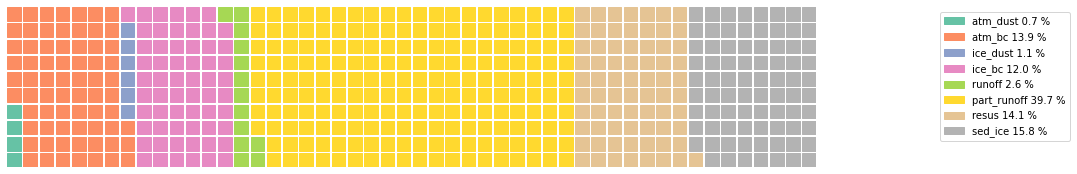

In [90]:
Label_per = [str(round(i*100/sum(total_yearly.values()),1))+' %' for i in total_yearly.values()]
names     = list(total_yearly.keys())

fig = plt.figure(FigureClass=Waffle, 
                 rows=10, columns=50,
                 values=list(total_yearly.values()), 
                 labels=[i+' '+j for i,j in zip(names, Label_per)],
                 figsize = (15,6),
                 colors=['','','','',\
                         '','','',''],
                 legend={'loc':'upper right','bbox_to_anchor': (1.32, 1), },)
plt.tight_layout()
plt.show()

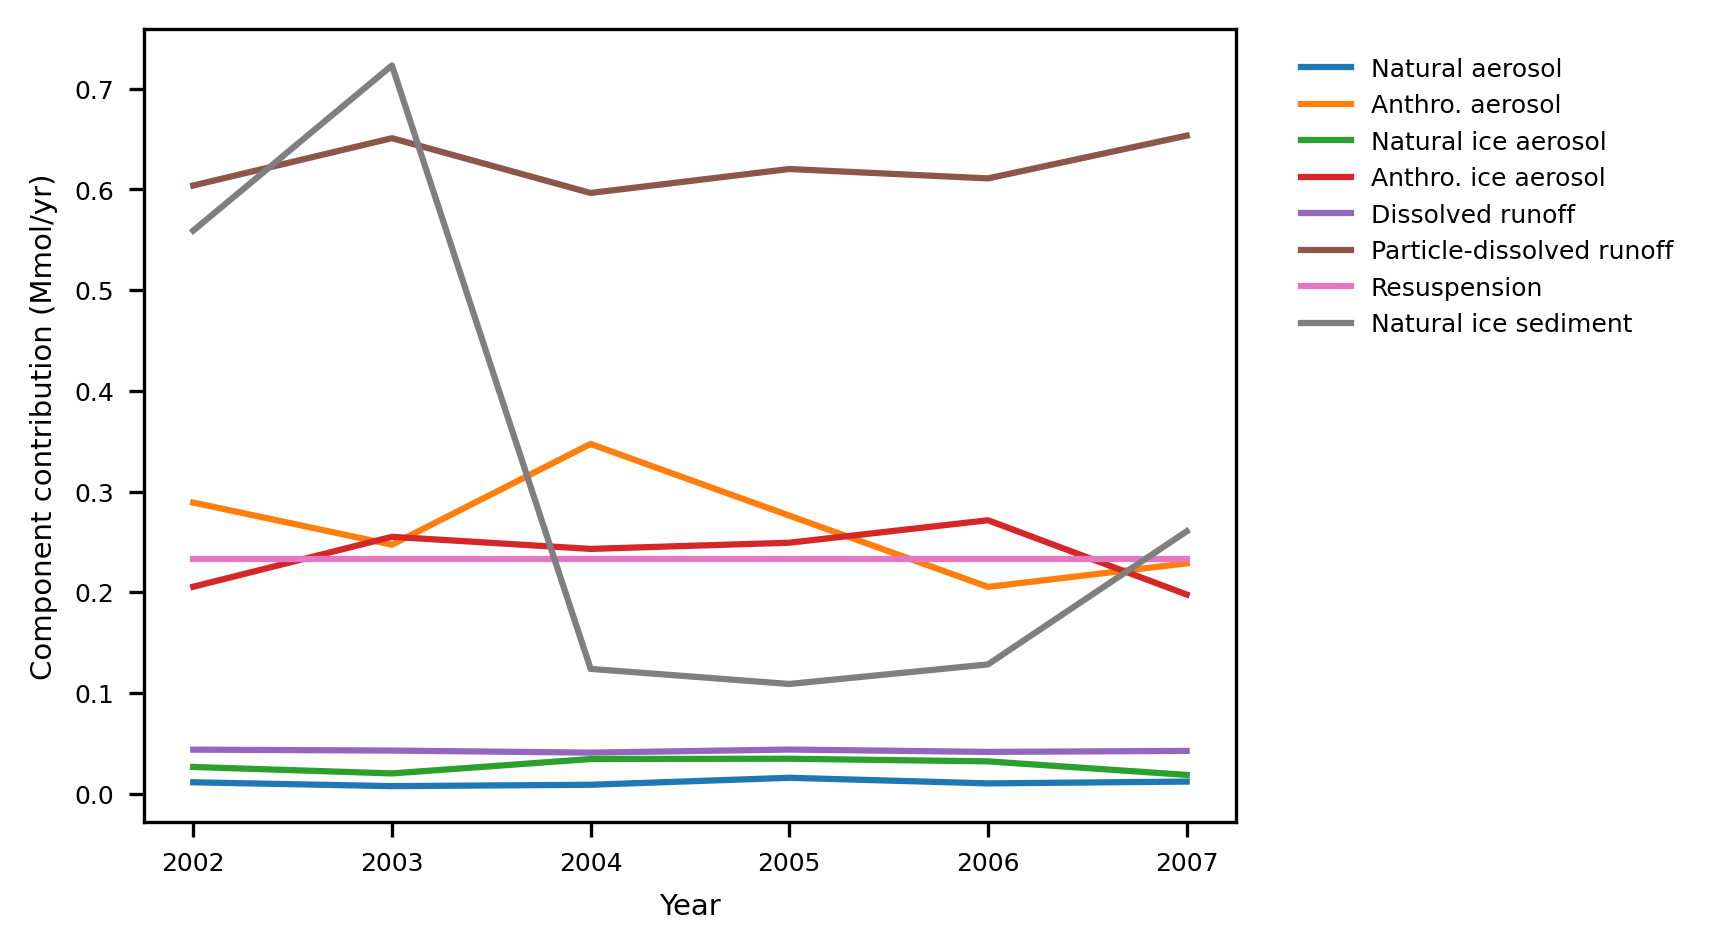

In [75]:
fig, ax = plt.subplots(1,1, figsize=(4.7,3.5), dpi=300)

labels = ['Natural aerosol','Anthro. aerosol','Natural ice aerosol','Anthro. ice aerosol',\
          'Dissolved runoff','Particle-dissolved runoff','Resuspension','Natural ice sediment']
for ind,key in enumerate(timeseries_total):
    ax.plot(years, timeseries_total[key]*1e-6, label=f'{labels[ind]}')
    
# ax.plot(years, sum(timeseries_total.values())*1e-6, label='Sum')

ax.set_xlabel('Year', fontsize=7)
ax.set_ylabel('Component contribution (Mmol/yr)', fontsize=7)
ax.tick_params(axis='both', labelsize=6)
ax.legend(loc=(1.05, 0.6), fontsize=6, frameon=False)

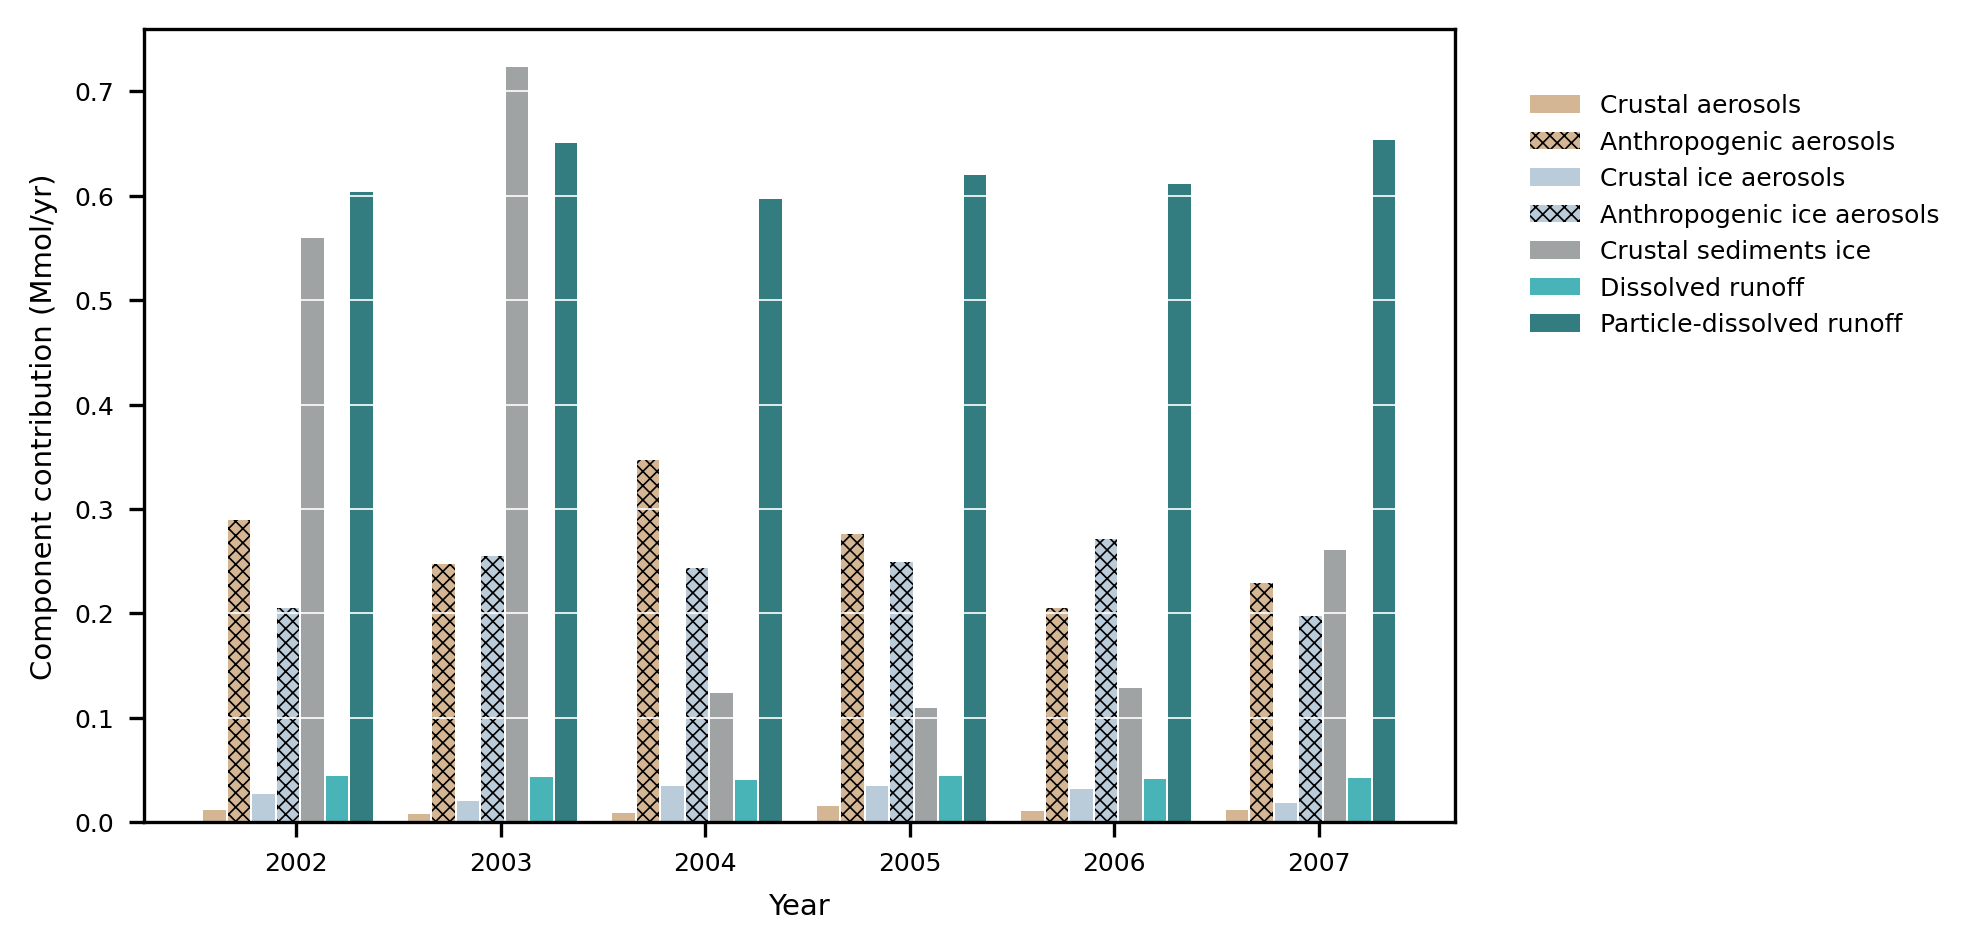

In [146]:
fig, ax = plt.subplots(1,1, figsize=(4.7*1.2,3.5), dpi=300)

colors  = ['#d4b694','#d4b694','#bacbda','#bacbda',
           '#a0a3a3','#49b4b8','#337d80']

patterns=['','xxxxxxx','','xxxxxxx','','', '']

keys   = ['atm_dust','atm_bc','ice_dust','ice_bc','sed_ice','runoff','part_runoff']
labels = ['Crustal aerosols','Anthropogenic aerosols','Crustal ice aerosols','Anthropogenic ice aerosols',\
          'Crustal sediments ice', 'Dissolved runoff','Particle-dissolved runoff']

mpl.rcParams['hatch.linewidth'] = 0.4
mpl.rcParams['hatch.color']     = 'k'
for ind, key in enumerate(keys):
    ax.bar([year-0.4 + 0.12*ind for year in years], timeseries_total[key]*1e-6, label=labels[ind],
            width=0.11, color=colors[ind], hatch=patterns[ind])

ax.grid(color='white', axis='y', linewidth=0.4)
ax.set_xlabel('Year', fontsize=7)
ax.set_ylabel('Component contribution (Mmol/yr)', fontsize=7)
ax.tick_params(axis='both', labelsize=6)
ax.legend(loc=(1.05, 0.6), fontsize=6, frameon=False)

In [32]:
colors  = ['#d4b694','#d4b694','#bacbda','#bacbda',
           '#a0a3a3','#49b4b8','#337d80']

# patterns=['','xxxxxxx','','xxxxxxx','','', '']
patterns=['','.....','','.....','','', '']

keys   = ['atm_dust','atm_bc','ice_dust','ice_bc','sed_ice','runoff','part_runoff']
labels = ['Crustal aerosols','Anthropogenic aerosols','Crustal ice aerosols','Anthropogenic ice aerosols',\
          'Crustal sediments ice', 'Dissolved runoff','Particle-dissolved runoff']

mpl.rcParams['hatch.linewidth'] = 0.5
mpl.rcParams['hatch.color']     = 'k'

In [ ]:
fig, ax = plt.subplots(2,1, figsize=(4.7*1.2,3.5*1.5), dpi=300, gridspec_kw={'height_ratios': [0.8, 2]})

# top plot:
    
ax[0].plot(years, sum(timeseries_total.values())*1e-6, '.-k', linewidth=0.8, label='Sum', zorder=1) # includes resuspension currently
# ax[0].grid(color='w', axis='y', linewidth=0.5, zorder=2)
ax[0].set_ylabel('Total addition (Mmol/yr)', fontsize=7)
ax[0].set_ylim(1.0, 2.5)

# bottom plot
for ind, key in enumerate(keys):
    ax[1].bar([year-0.4 + 0.12*ind for year in years], timeseries_total[key]*1e-6, label=labels[ind],
            width=0.11, color=colors[ind], hatch=patterns[ind])

ax[1].grid(color='white', axis='y', linewidth=0.5)
ax[1].set_xlabel('Year', fontsize=7)
ax[1].set_ylabel('Addition by source (Mmol/yr)', fontsize=7)
ax[1].legend(loc=(1.05, 0.6), fontsize=6, frameon=False)

for axis in ax.ravel():
    axis.tick_params(axis='both', labelsize=6)

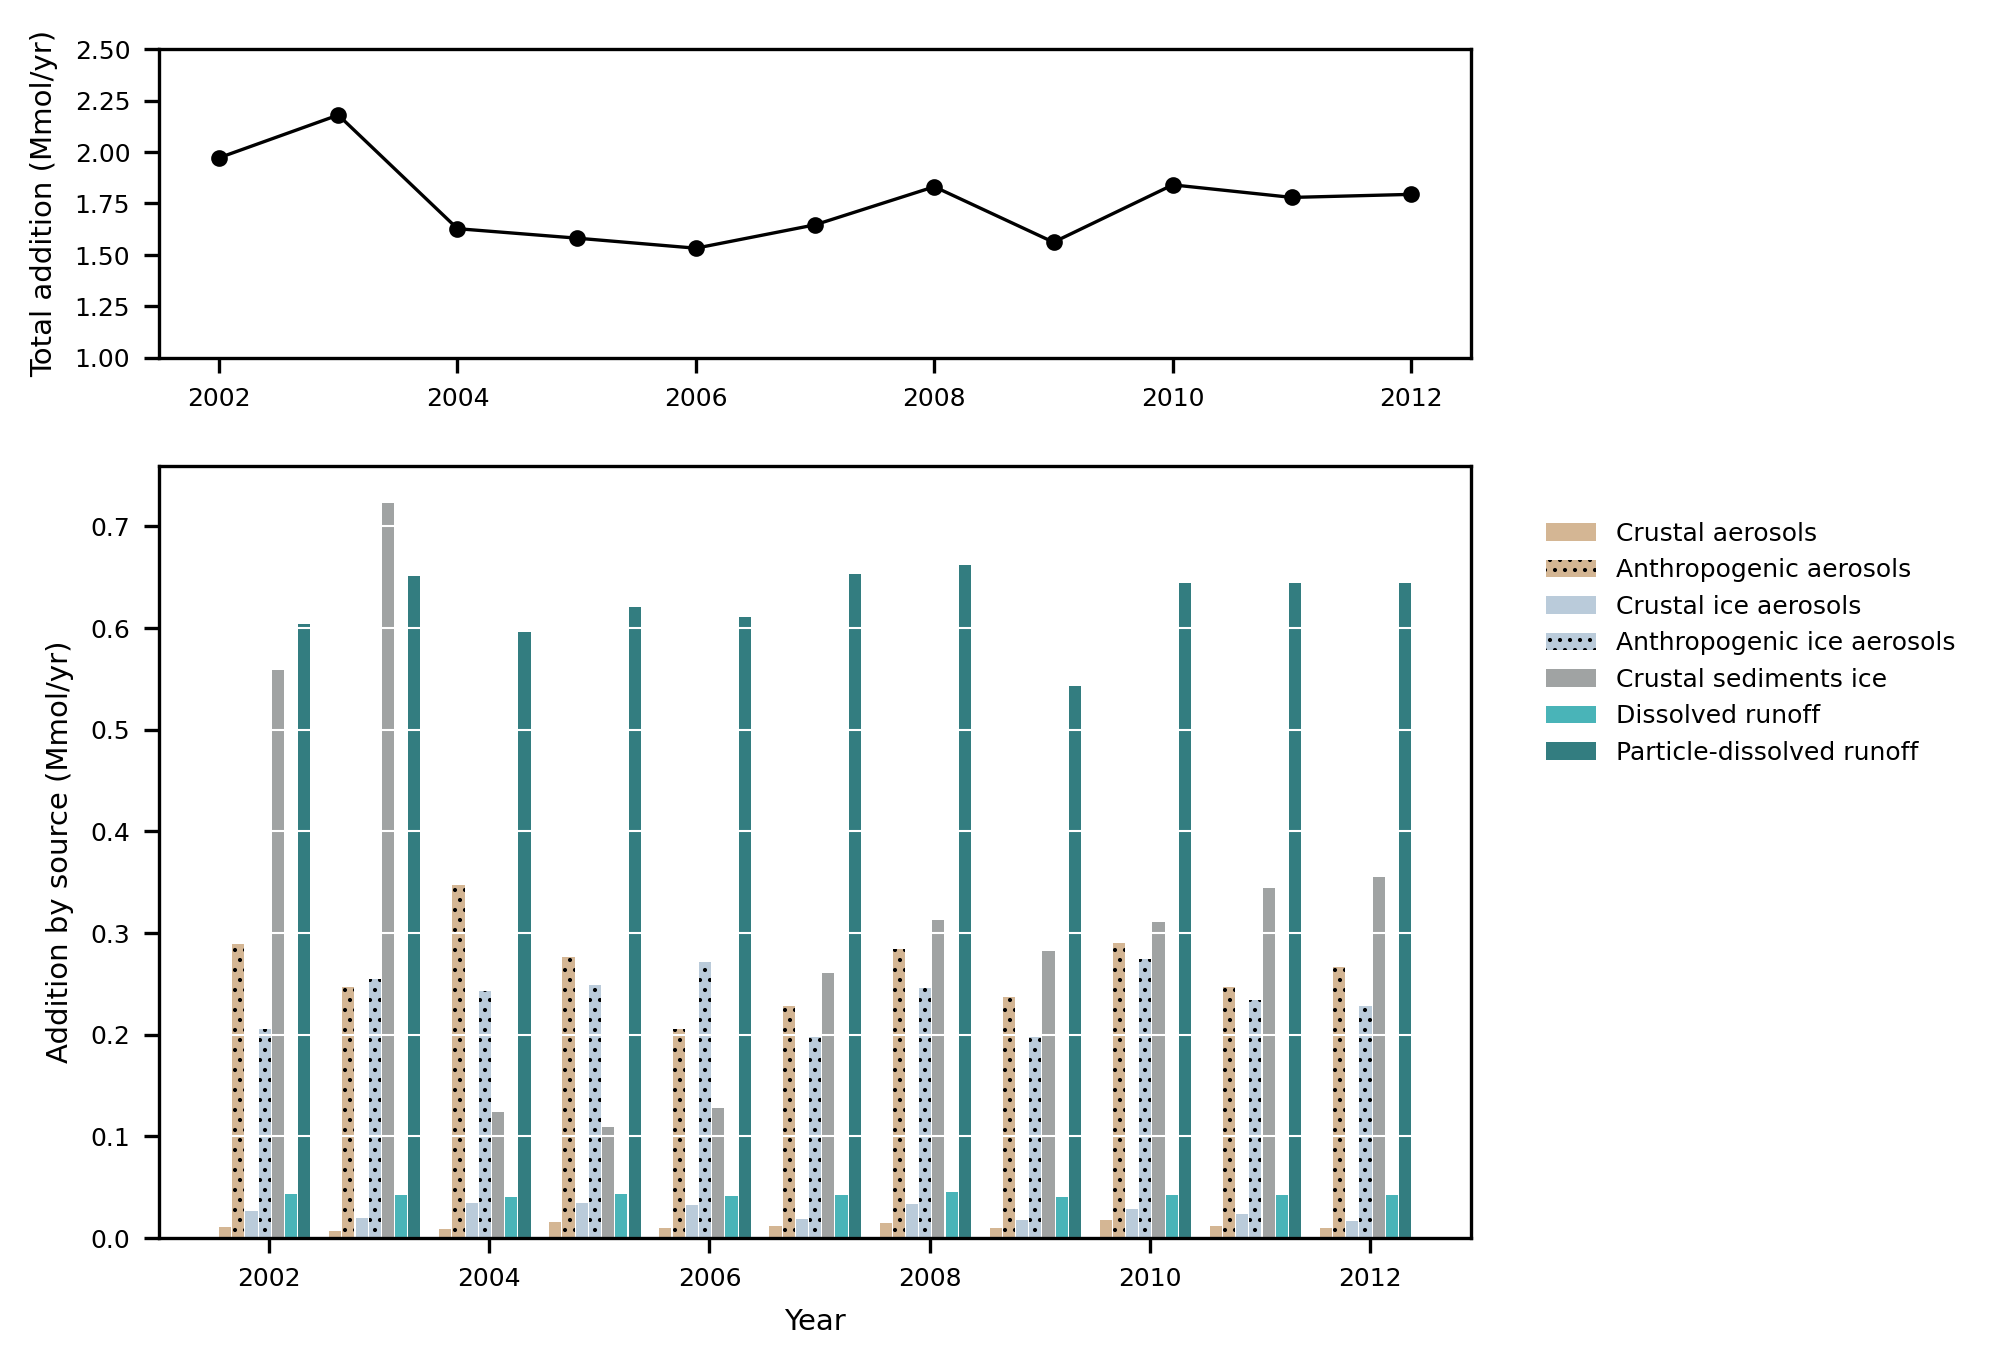

In [36]:
fig, ax = plt.subplots(2,1, figsize=(4.7*1.2,3.5*1.5), dpi=300, gridspec_kw={'height_ratios': [0.8, 2]})

# top plot:
    
ax[0].plot(years, sum(timeseries_total.values())*1e-6, '.-k', linewidth=0.8, label='Sum', zorder=1) # includes resuspension currently
# ax[0].grid(color='w', axis='y', linewidth=0.5, zorder=2)
ax[0].set_ylabel('Total addition (Mmol/yr)', fontsize=7)
ax[0].set_ylim(1.0, 2.5)

# bottom plot
for ind, key in enumerate(keys):
    ax[1].bar([year-0.4 + 0.12*ind for year in years], timeseries_total[key]*1e-6, label=labels[ind],
            width=0.11, color=colors[ind], hatch=patterns[ind])

ax[1].grid(color='white', axis='y', linewidth=0.5)
ax[1].set_xlabel('Year', fontsize=7)
ax[1].set_ylabel('Addition by source (Mmol/yr)', fontsize=7)
ax[1].legend(loc=(1.05, 0.6), fontsize=6, frameon=False)

for axis in ax.ravel():
    axis.tick_params(axis='both', labelsize=6)

## Calculate inflow/outflow through the boundaries
Boundaries:
- western Canada Basin
- northern Canada Basin
- Labrador Sea

In [ ]:
# estimate at a transect just a bit on from the boundary. Need: dPb concentration and flow volume 
# mol/L * m3 / s * 1e3 L/m3 = mol/s * 3600*24*days_in_month = mol / month (sum over year) --> mol/yr *1e-6 = Mmol/yr
# so the main input parameter I need is the flow rate at each of these boundaries